<a href="https://colab.research.google.com/github/arumajirou/ETNA/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EDA notebook

<a href="https://mybinder.org/v2/gh/tinkoff-ai/etna/master?filepath=examples/EDA.ipynb">
    <img src="https://mybinder.org/badge_logo.svg"  align='left'>
</a>

このノートブックには、ETNAライブラリを使ったEDA（探索的データ解析）の簡単な例が掲載されています。

**目次**

- TSDatasetの作成
- 可視化
 - プロット
 - 自己相関
 - 相互相関
 - 相関ヒートマップ
 - 流通
 - トレンド
 - 季節性
- 異常値
 - メディアン方式
 - 密度法
- 変更点

In [1]:
import warnings

warnings.filterwarnings("ignore")

# **1.TSDatasetの作成**

データセットをロードして見てみましょう。

In [2]:
import pandas as pd

In [3]:
csv_path1 ="https://github.com/tinkoff-ai/etna/raw/master/examples/data/example_dataset.csv"
classic_df = pd.read_csv(csv_path1)
classic_df.head()

,timestamp,segment,target
0,2019-01-01,segment_a,170
1,2019-01-02,segment_a,243
2,2019-01-03,segment_a,267
3,2019-01-04,segment_a,287
4,2019-01-05,segment_a,279


本ライブラリは、空間データ構造TSDatasetで動作します。そこで、EDAを始める前に、古典的なDataFrameをTSDatasetに変換する必要があります。

In [4]:
!pip install --upgrade pip
!pip install etna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
from etna.datasets.tsdataset import TSDataset

そのためには、まず、従来のDataFrameを特殊な形式に変換する必要があります。

In [6]:
df = TSDataset.to_dataset(classic_df)
df.head()

segment,segment_a,segment_b,segment_c,segment_d
feature,target,target,target,target
timestamp,,,,
2019-01-01,170,102,92,238
2019-01-02,243,123,107,358
2019-01-03,267,130,103,366
2019-01-04,287,138,103,385
2019-01-05,279,137,104,384


これで、TSDatasetを構築することができます。

In [7]:
ts = TSDataset(df, freq="D")
ts.head(5)

segment,segment_a,segment_b,segment_c,segment_d
feature,target,target,target,target
timestamp,,,,
2019-01-01,170,102,92,238
2019-01-02,243,123,107,358
2019-01-03,267,130,103,366
2019-01-04,287,138,103,385
2019-01-05,279,137,104,384


TSDataset はdescribeとinfoメソッドを独自に実装しており、個別の時系列に関する情報を提供します。

In [8]:
ts.describe()

,start_timestamp,end_timestamp,length,num_missing,num_segments,num_exogs,num_regressors,num_known_future,freq
segments,,,,,,,,,
segment_a,2019-01-01,2019-11-30,334,0,4,0,0,0,D
segment_b,2019-01-01,2019-11-30,334,0,4,0,0,0,D
segment_c,2019-01-01,2019-11-30,334,0,4,0,0,0,D
segment_d,2019-01-01,2019-11-30,334,0,4,0,0,0,D


In [9]:
ts.info()

<class 'etna.datasets.TSDataset'>
num_segments: 4
num_exogs: 0
num_regressors: 0
num_known_future: 0
freq: D
          start_timestamp end_timestamp  length  num_missing
segments                                                    
segment_a      2019-01-01    2019-11-30     334            0
segment_b      2019-01-01    2019-11-30     334            0
segment_c      2019-01-01    2019-11-30     334            0
segment_d      2019-01-01    2019-11-30     334            0


# **2.ビジュアル化**

我々のライブラリは、データを視覚的に探索するためのユーティリティのリストを提供しています。さて、データセットがTSDatasetに変換されたので、次はそれを可視化します。

In [10]:
from etna.analysis import (
    cross_corr_plot,#複数の時系列間の相互相関プロット。
    distribution_plot,#セグメントと時間頻度でグループ化したz値の分布。
    acf_plot,#複数の時系列に対する自己相関と偏自己相関のプロット。
    plot_correlation_matrix,#選択したセグメントについて、ペアワイズコリレーションヒートマップをプロットします。
)

### **2.1 時系列のプロット**
データセットの時系列を見てみましょう。

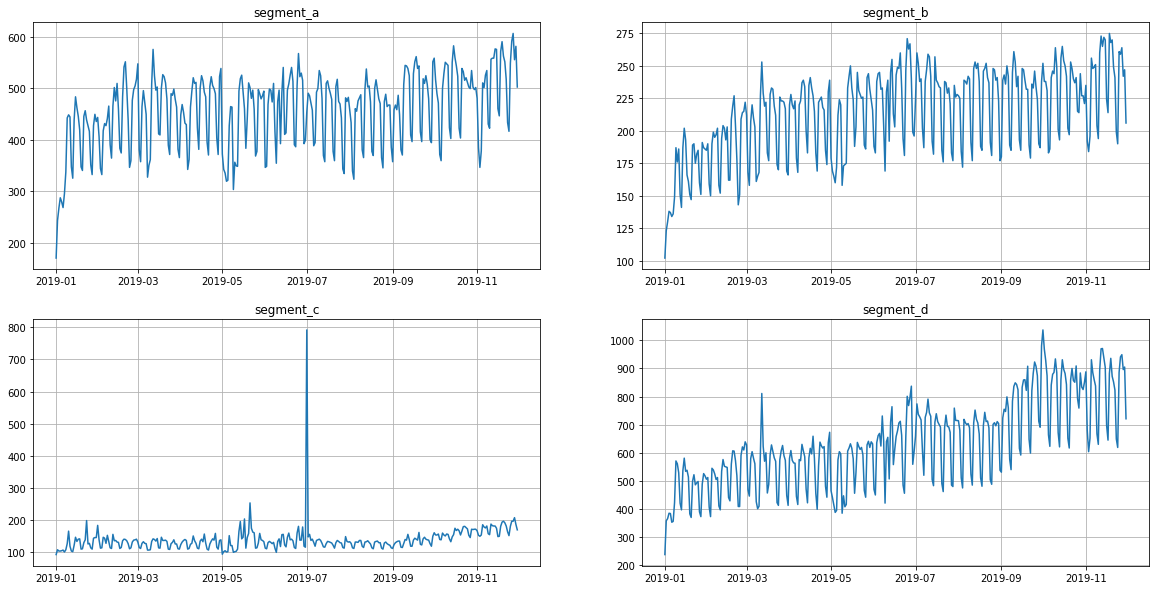

In [11]:
ts.plot()

### **2.2 自己相関と偏自己相関**
- 自己相関関数(AFC)は、ある観測値とそのラグとの間の直接的な関係を記述する。
  - AFCプロットは、移動平均モデルにおけるラグの程度を識別するのに役立つ。

- 偏自己相関関数(PAFC) は，オブザベーションとそのラグとの間の直接的な関係性を記述する．
 - PAFC プロットは，自己回帰モデルにおけるラグの程度を識別するのに役立つ．

- ラグの最大数を指定して、時系列のAFCとPAFCのプロットを観察してみましょう。

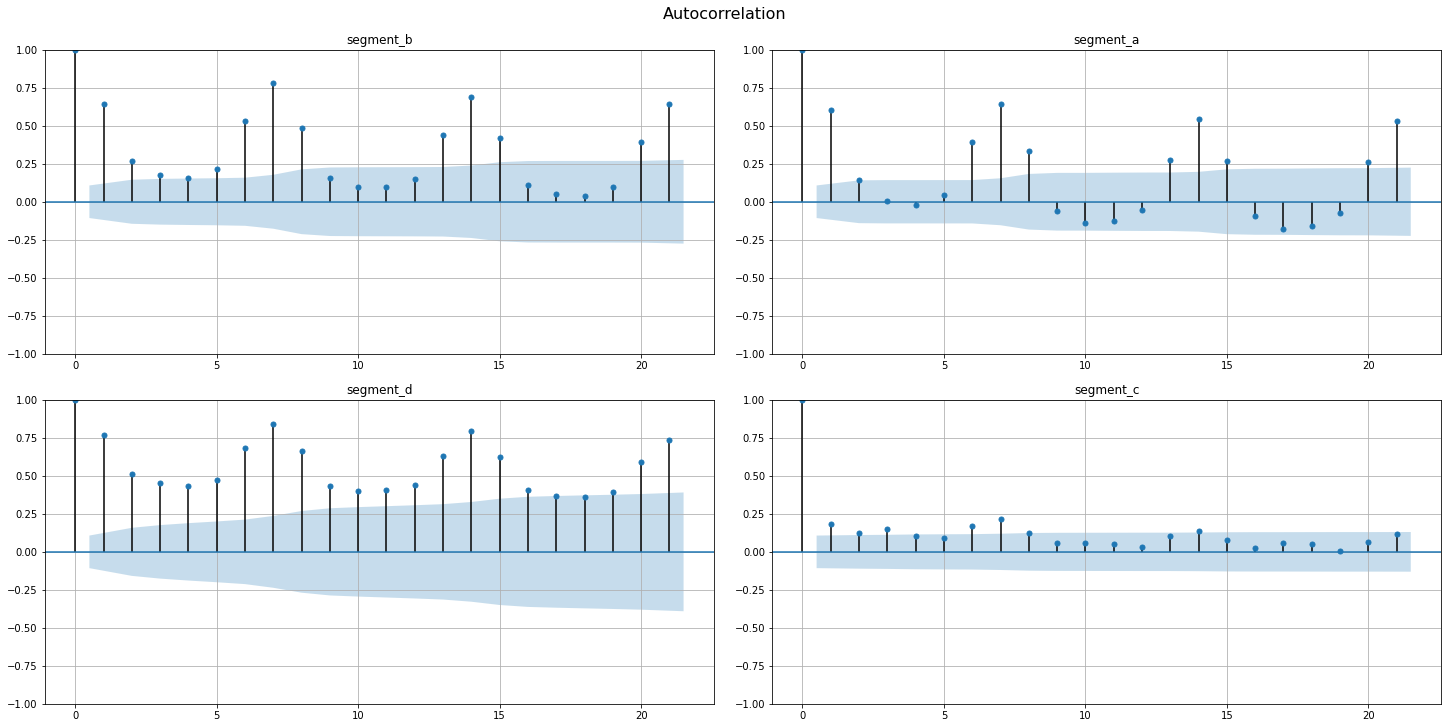

In [12]:
acf_plot(ts, lags=21)

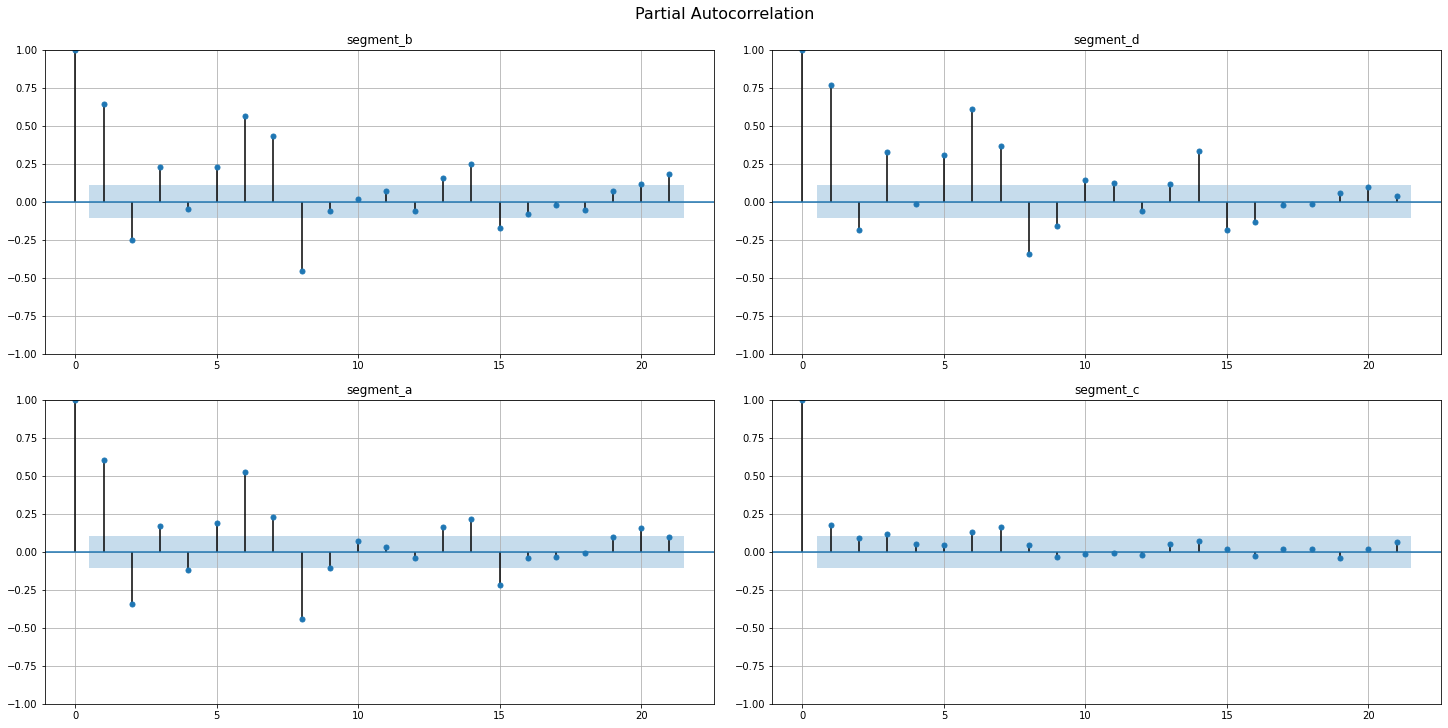

In [13]:
acf_plot(ts, lags=21, partial=True)

### **2.3 相互相関**
- 相互相関は、一般に複数の時系列を比較し、それらがどの程度一致するか、特にどの時点で最も一致するかを判断するために使用されます。
 - 相互相関の値が  1 であればあるほど、その集合はより密接に同一である。

- データセット内のすべての時系列のペアの相互相関をプロットしてみよう。


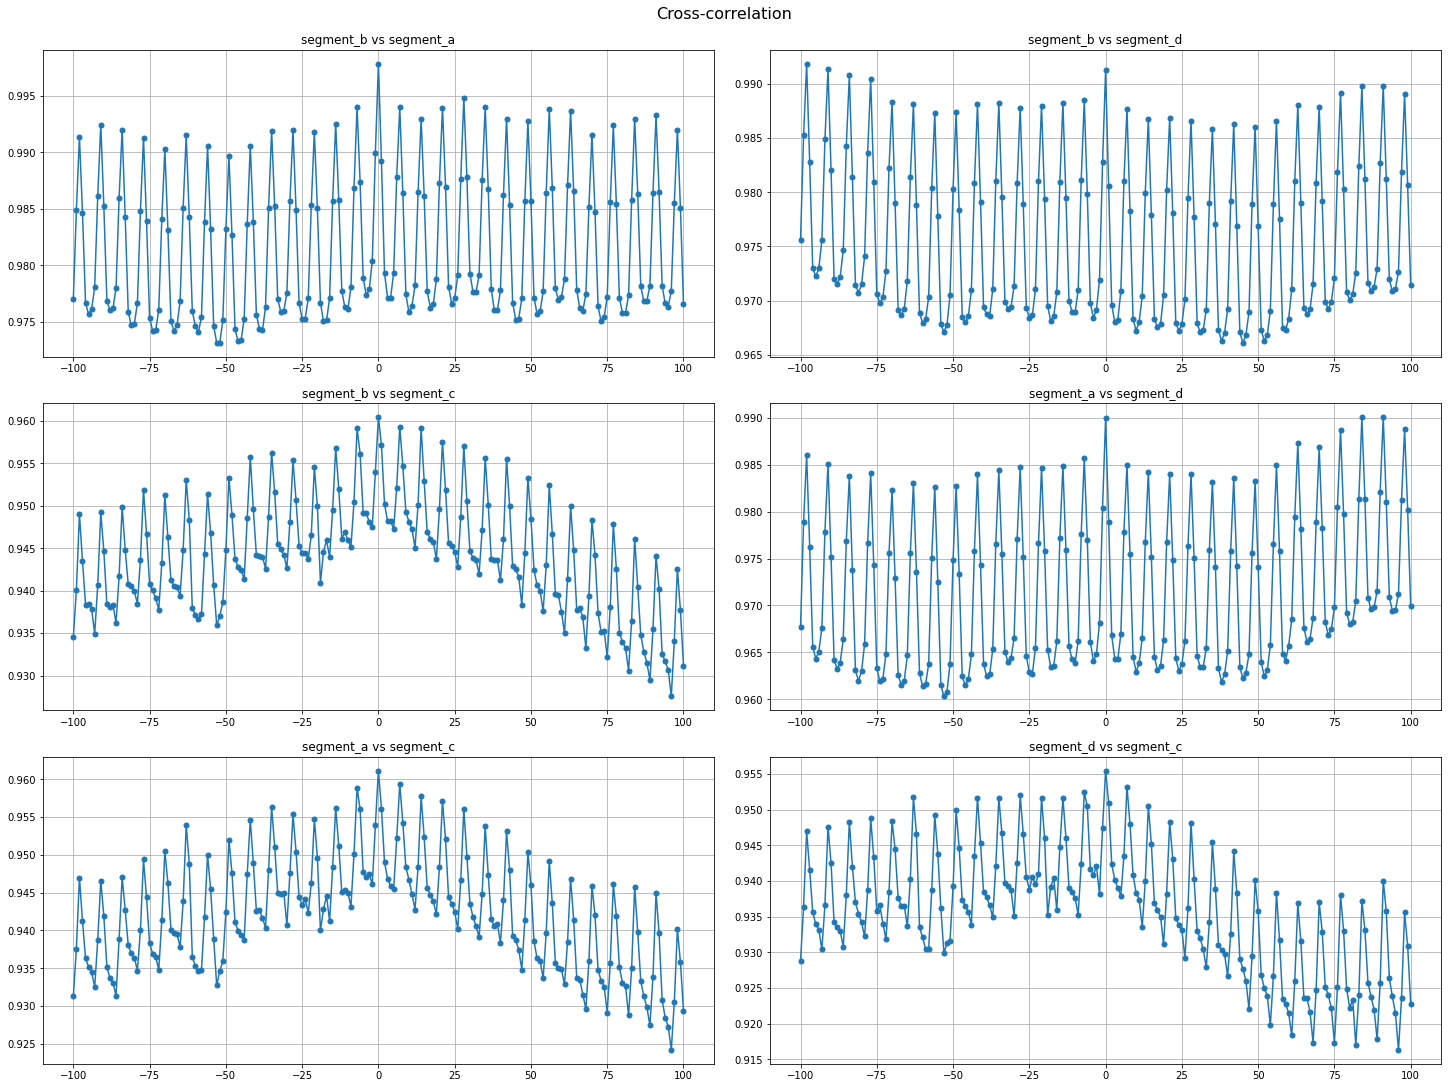

In [14]:
cross_corr_plot(ts, maxlags=100)

### **2.4 相関ヒートマップ**
- 相関ヒートマップは、データセット内の時系列間のペアワイズ相関マトリックスを視覚化したものです。
 - データセット内の相関のある時系列を判断するためのシンプルなビジュアルツールです。

- 相関があるけれどもずれがあるシリーズをキャッチするために、データセットにラグの列を追加して、相関ヒートマップを見てみましょう。

In [15]:
#指定されたデータフレームから一連のラグを生成します。
from etna.transforms import LagTransform

In [16]:
#指定されたデータフレームから一連のラグを生成します。
lags = LagTransform(in_column="target",#in_column(str) - 処理されるカラムの名前
                    lags=[1, 7],#ラグ計算のためのint値 1~7
                    out_column="lag"#作成されたカラムの名前のベースとなる。
                    )
print("lags =",lags)
ts.fit_transform([lags])

lags = LagTransform(in_column = 'target', lags = [1, 7], out_column = 'lag', )


TypeError: ignored

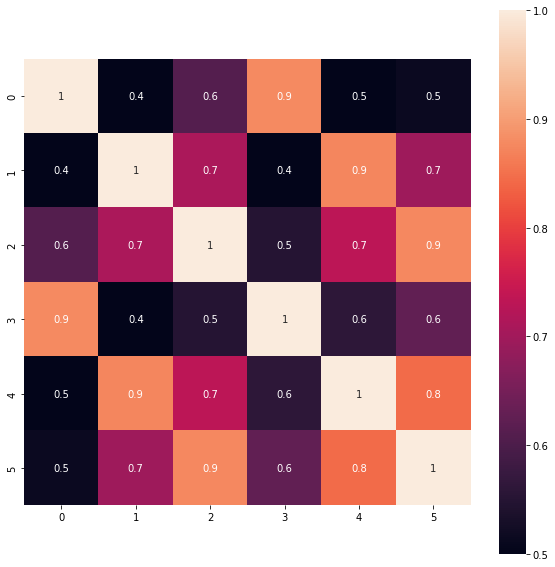

In [17]:
plot_correlation_matrix(
    ts,#時系列データを含むTSDataset
    segments=["segment_a", "segment_b"],# 使用する列，もし None ならば全ての列を使用する．
    method="spearman",#相関の方法。 ここではスペアマン順位相関
    vmin=0.5,#最小値
    vmax=1#最大値
    )

### **2.5 配信**
- セグメントと時間頻度でグループ化されたz値の分布。
 - このプロットを使って、データの時間的なドリフトを監視することができます。

- データセット内の各年の分布を比較してみましょう。

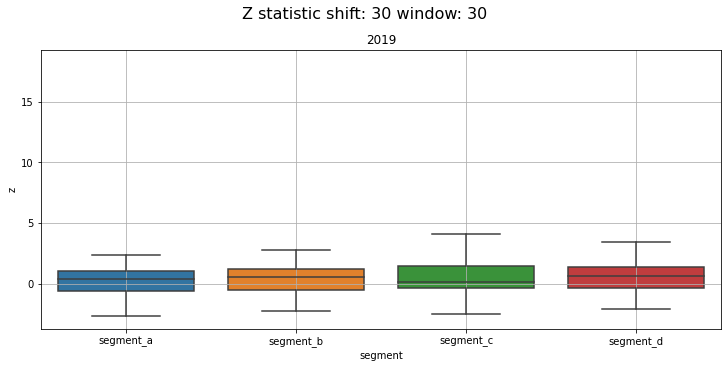

In [18]:
distribution_plot(ts, freq="1Y")


### **2.6 トレンド**

- 時系列には、このようにトレンドという重要な性質があります。
 - plot_trendを使用すると、各セグメントのトレンドを視覚化し、それを記述する適切なモデルを選択することができます。

- 例えば、リニアとパラボリックのトレンドを構築してみましょう。

In [19]:
#この系列に対してトレンド変換を行い、系列とトレンドをプロットします。
from etna.analysis import plot_trend
#データの線形または多項式の傾向を見つける変換を行います。
from etna.transforms import LinearTrendTransform

In [20]:
trends = [
    LinearTrendTransform(in_column="target",#処理されるカラムの名前．
                         poly_degree=1),#トレンドにフィットさせる多項式の次数。
    LinearTrendTransform(in_column="target",#処理されるカラムの名前．
                         poly_degree=2),#トレンドにフィットさせる多項式の次数。
]
print("trends=",trends)

trends= [LinearTrendTransform(in_column = 'target', poly_degree = 1, ), LinearTrendTransform(in_column = 'target', poly_degree = 2, )]


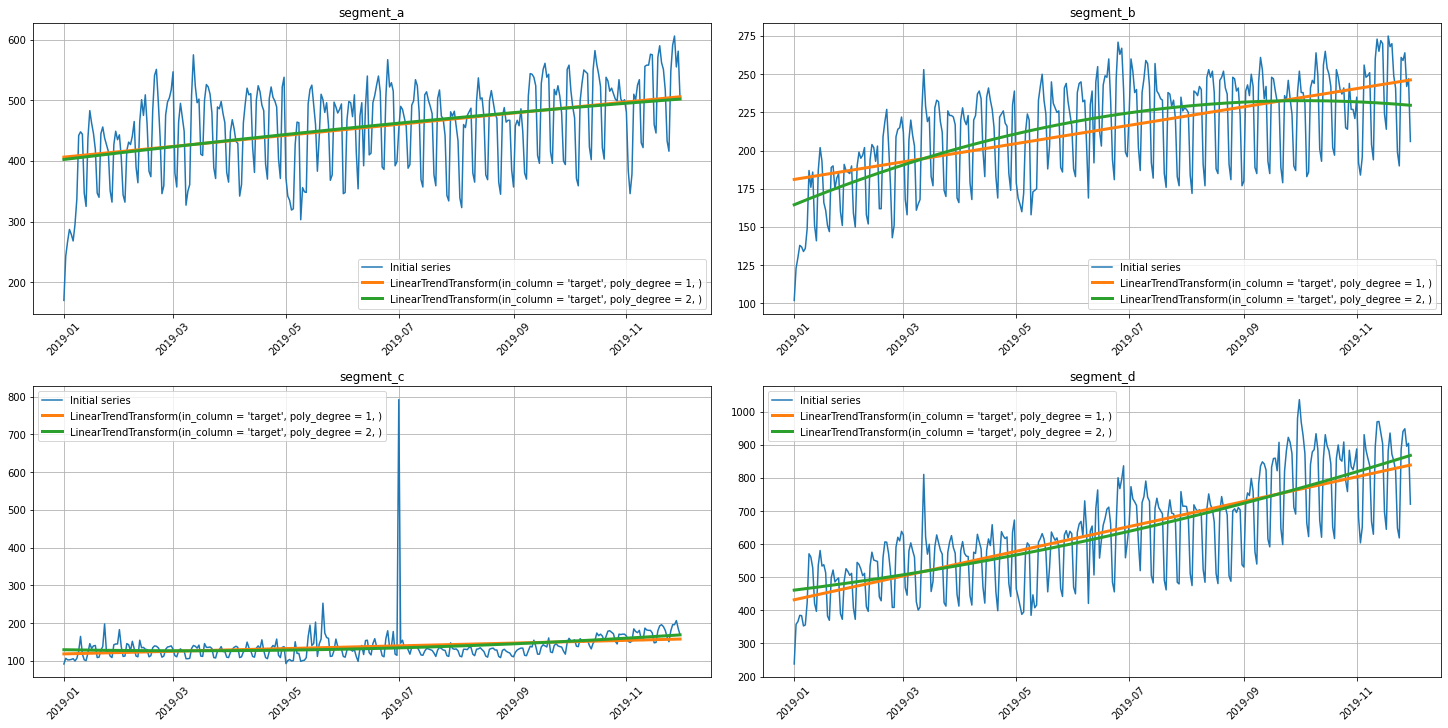

In [21]:
plot_trend(ts, #トレンドプロットに使用された時系列のデータフレーム
           trend_transform=trends#トレンド変換、または適用するトレンド変換のリスト
           )

### **2.7 季節性**

本ライブラリでは、季節性を分析するためのいくつかの手法を提供しています。

In [32]:
from etna.analysis import plot_periodogram, stl_plot, seasonal_plot

- 最初のplot_periodogramは，周期内のフーリエ成分の振幅を可視化するものです。
 - このメソッドは、FourierTransformの次数パラメータを決定するのに便利でしょう。
 - 経験則では、次数は振幅の最後の有意なピックとして設定します。

TypeError: ignored

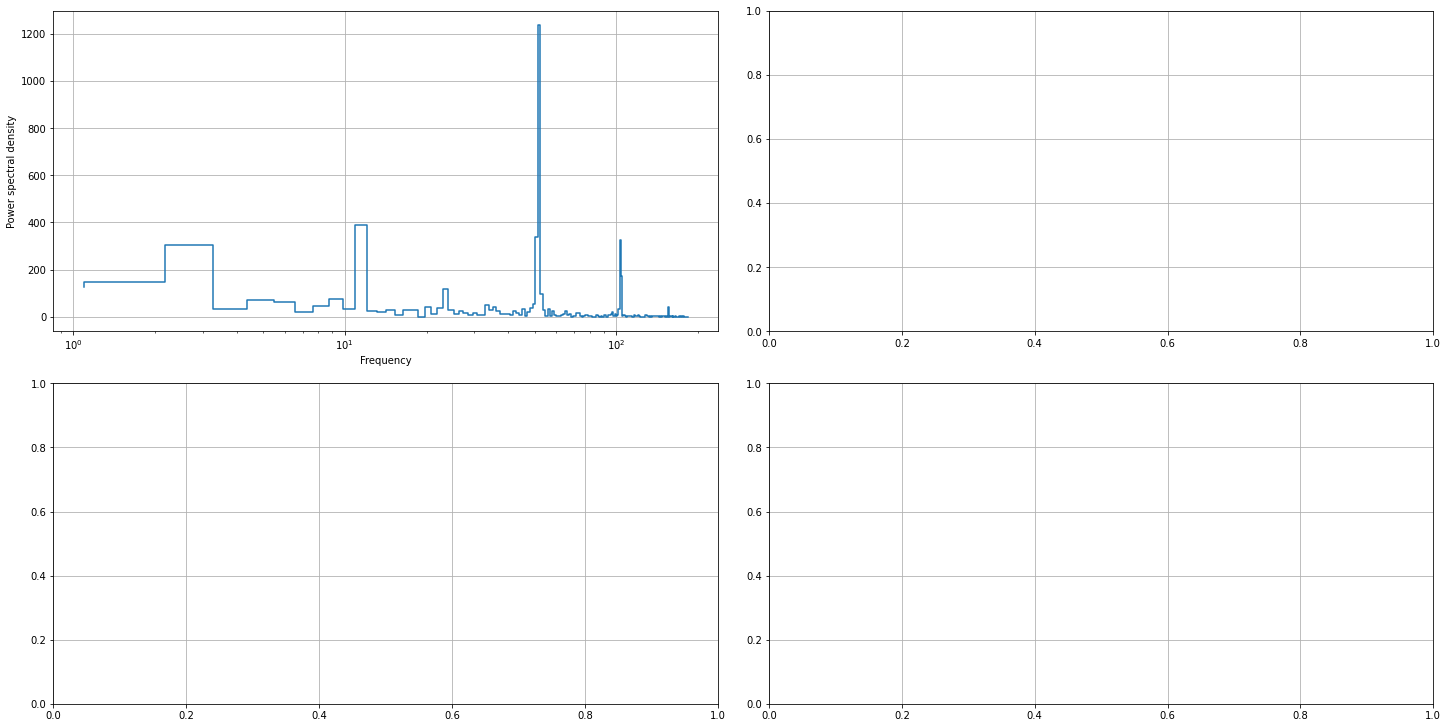

In [34]:
#ペリオドグラムをプロットします。
plot_periodogram(ts, # 時系列データを含むTSDataset．
                 period=365.2425,# 時系列の周波数単位で捉えた季節性の期間， >= 2である必要があります
                 amplitude_aggregation_mode="per-segment", #セグメント毎のペリオドグラムの集計方法．
                 xticks=[1, 2, 4, 6, 12, 26, 52, 104])# X軸の目盛り位置のリストで、特定の参照周期をハイライトするのに便利です。

- また、ピリオドグラムのpicsは、x=52付近で週単位（1年に52回）の季節性を示しており、対応する季節性の存在を示している。

stl_plotは、対応する分解を可視化したものです。

In [35]:
stl_plot(ts=ts, period=52)

AttributeError: ignored

<Figure size 1440x1440 with 0 Axes>

- 3つ目のseasonal_plotは、特定の期間（時間、日、週、月、四半期、年）の季節性を視覚化するのに役立ちます。
 - season_plotは、基本的な季節パターンをより明確に見ることができ、特にパターンが変化する期間を特定するのに有効である

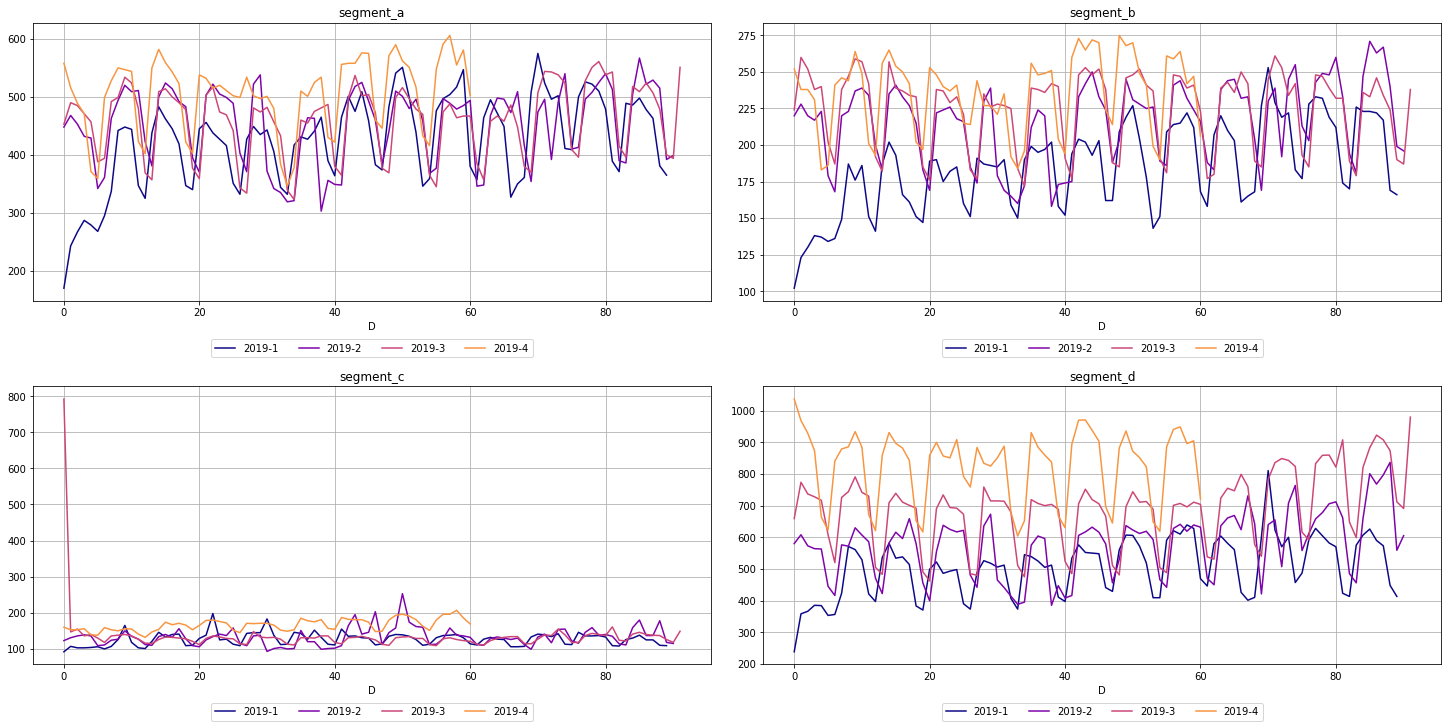

In [36]:
seasonal_plot(ts=ts, cycle="quarter")

# **3.異常値**

- 視覚的には、すべての時系列に外れ値（プロット上の異常なスパイク）が含まれています。
 - このような異常値の存在は、予測の質を低下させる原因となる可能性があります。

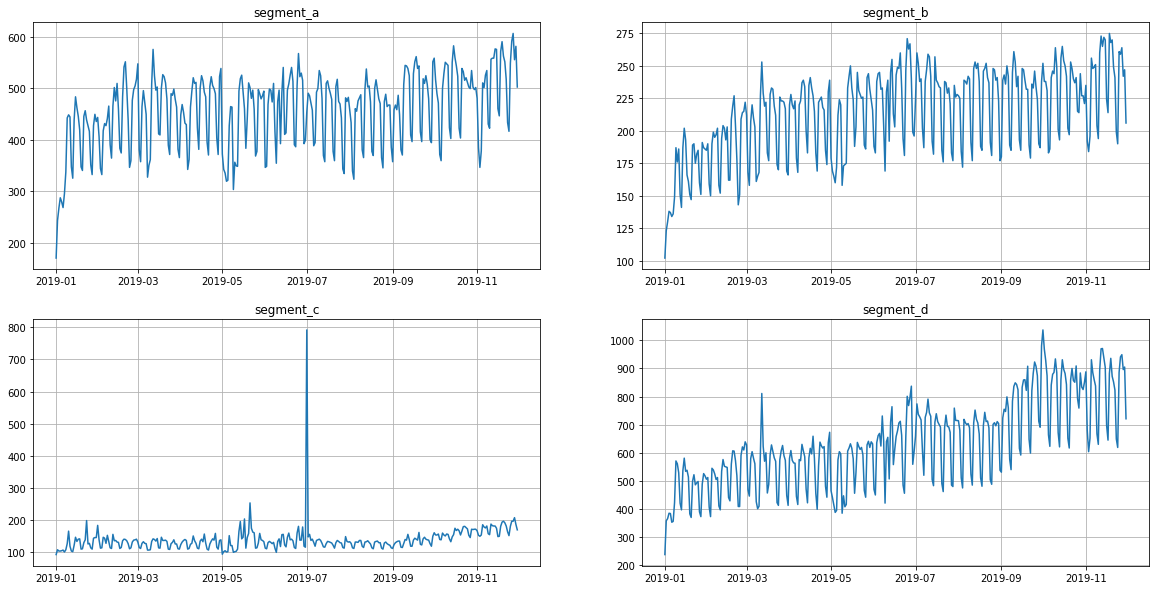

In [37]:
ts.plot()

- 当ライブラリでは、外れ値検出のための2つのメソッドを提供しています。
- また、検出された外れ値は、plot_anomaliesを用いて簡単に可視化することができます。

In [25]:
from etna.analysis.outliers import get_anomalies_median, get_anomalies_density
#表示されている異常値を時系列にプロットします。
from etna.analysis import plot_anomalies

### **3.1 中央値法**
- 中央値法を用いて点状異常値を得るためには、中央値モデルを当てはめるためのウィンドウを指定する必要がある。

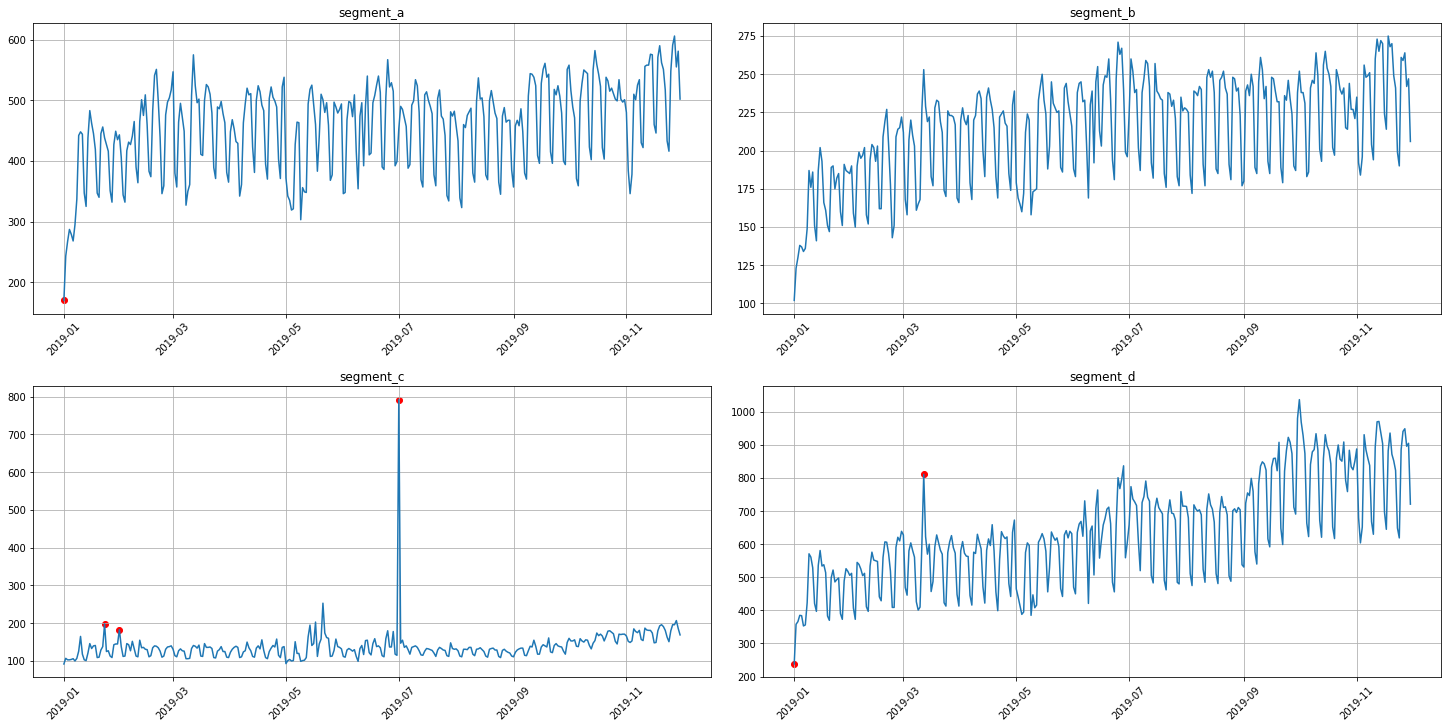

In [38]:
#中央値モデル（推定モデルベース法）を用いて時系列中の点状異常値を取得する。
#外れ値とは、中央値からalpha * std以上離れているすべての点のことで、stdはウィンドウ内の標本分散である。
anomaly_dict = get_anomalies_median(ts, #時系列データを含むTSDataset
                                    window_size=100)# ウィンドウ内のポイント数
plot_anomalies(ts,#異常の検出に使用されたタイムスケールのTSDataset。
               anomaly_dict)#異常検知関数から派生した辞書

### **3.2 密度法**
- 距離ベースの外れ値検出法です。
- デフォルトのパラメータに依存しない

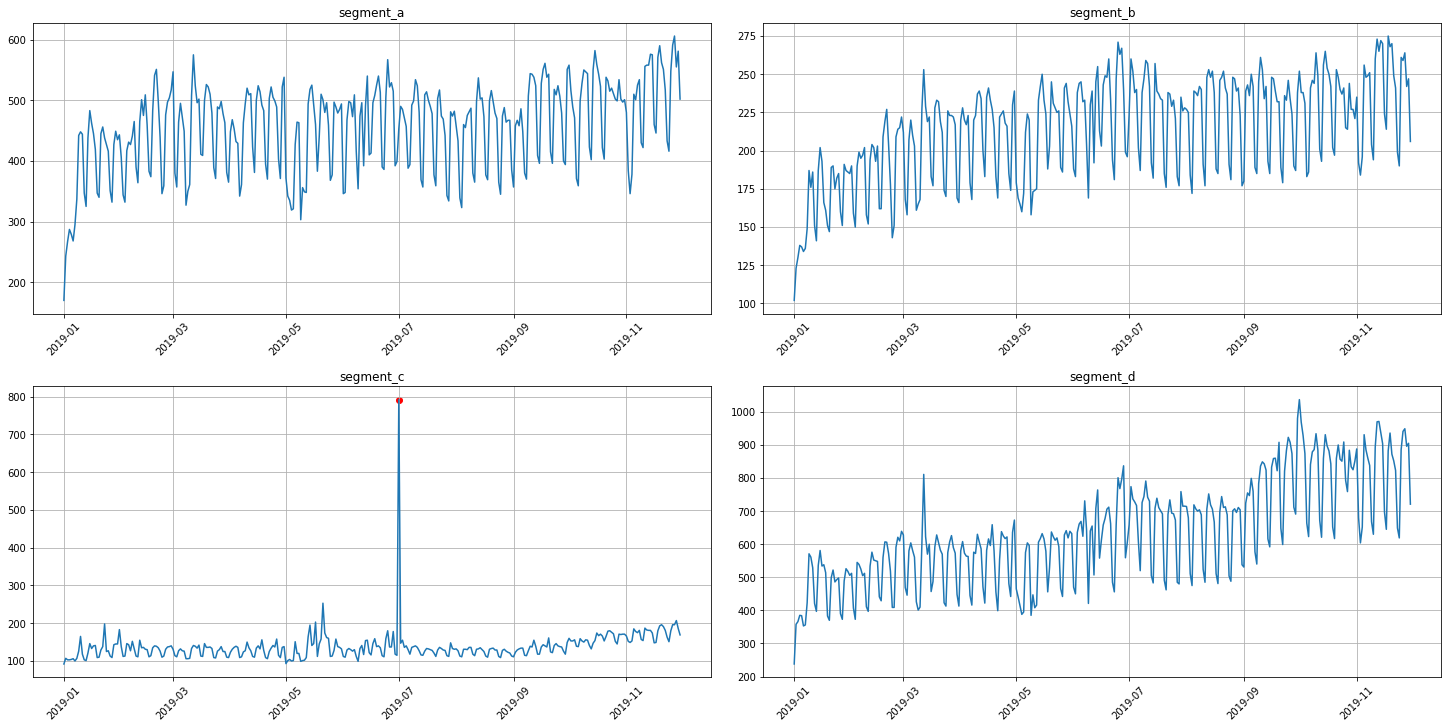

In [39]:
#密度則にしたがって外れ値を計算する。
#系列の各要素について、その点を含むwindow_sizeのウィンドウを全て構築する。 
#ウィンドウのいずれかが、distance_funcに従って対象点からdistance_coef * std(series)より近いn_neighborsを少なくとも含む場合、
#対象点は外れ値ではない。

anomaly_dict = get_anomalies_density(ts)#時系列データを含むTSDataset．
plot_anomalies(ts,#異常の検出に使用されたタイムスケールのTSDataset。
               anomaly_dict)#異常検知関数から派生した辞書

ここでのベストプラクティスは、データ用のメソッドパラメータを指定することです

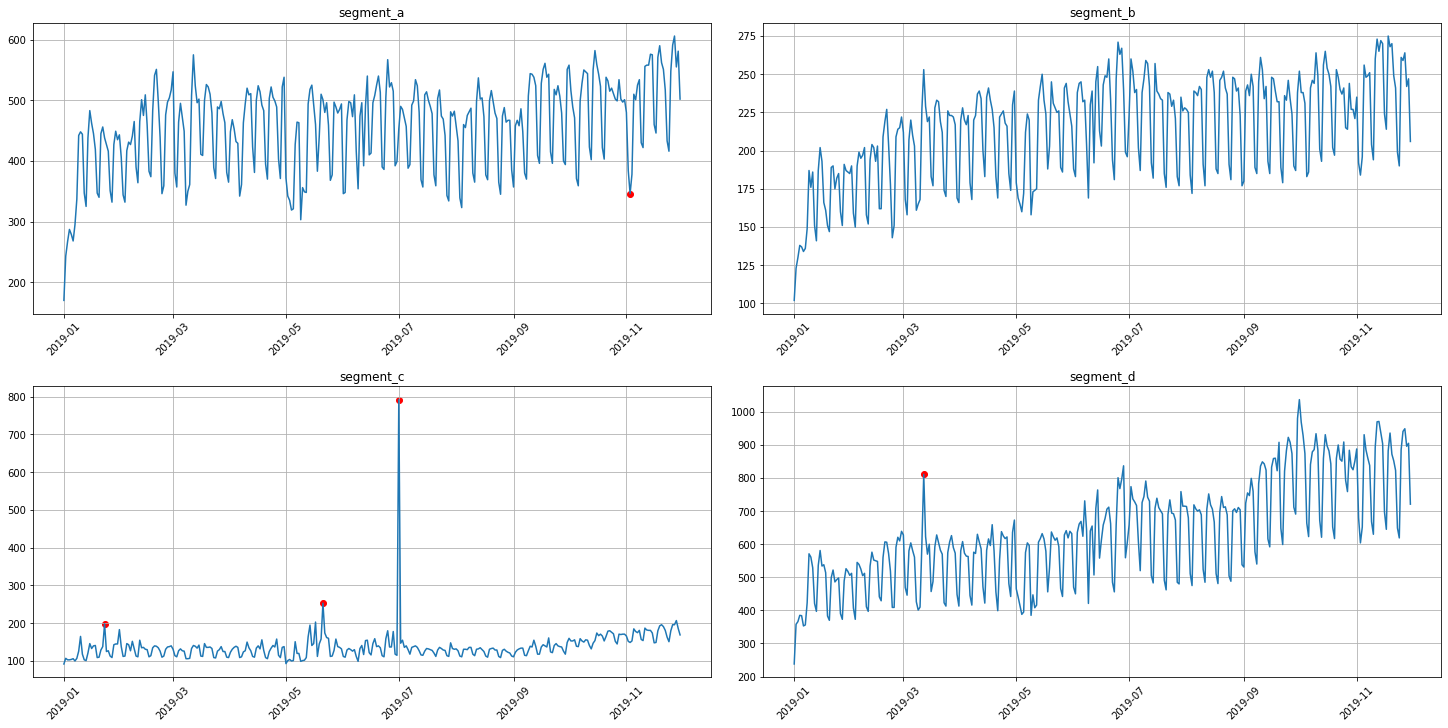

In [28]:
anomaly_dict = get_anomalies_density(ts, window_size=18, distance_coef=1, n_neighbors=4)
plot_anomalies(ts, anomaly_dict)

# **4.変更点**


- シリーズには、歴史的なトレンドの変化が含まれていることがあります。
- 変化を考慮したトレンドの識別と処理は、予測に役立つことがある

本ライブラリでは、変化点を可視化するための2つのメソッドを提供しています。

In [29]:
from etna.analysis import plot_time_series_with_change_points, plot_change_points_interactive
from etna.analysis import find_change_points
from ruptures.detection import Binseg

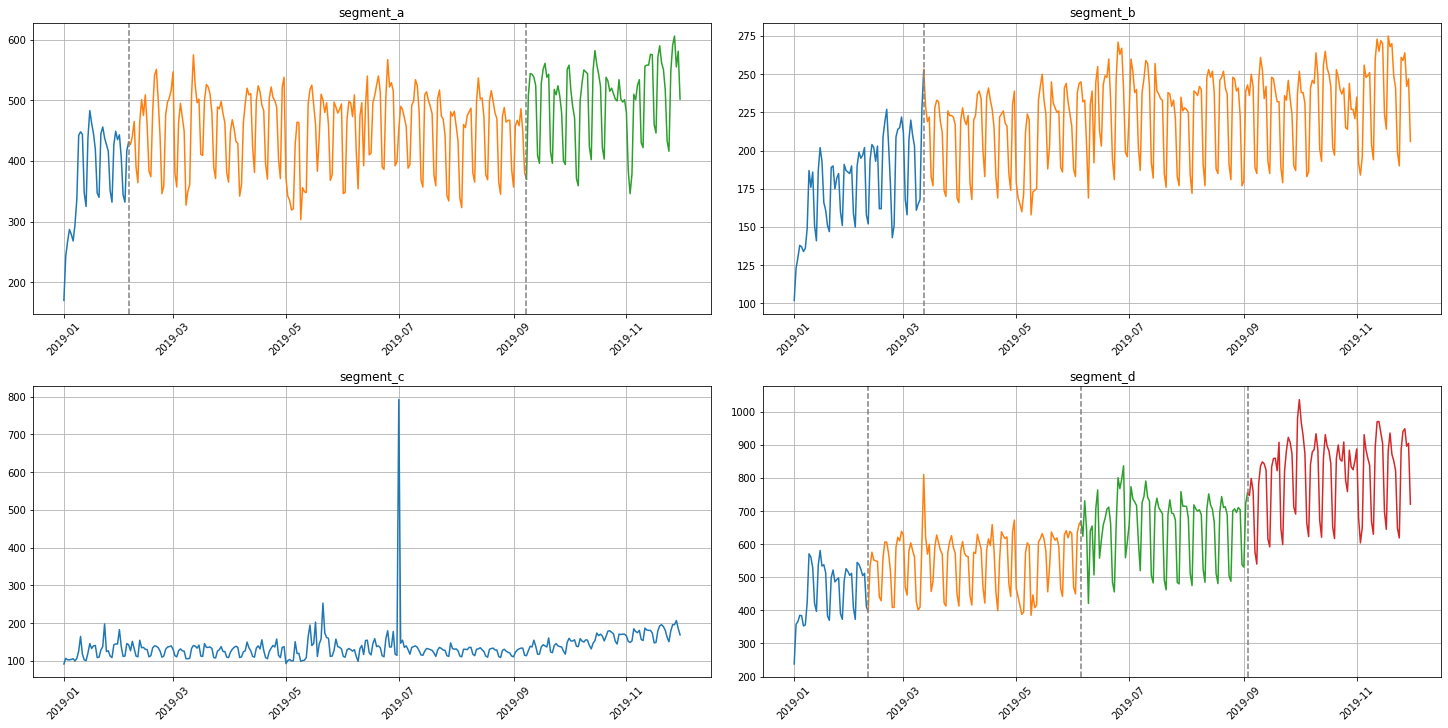

In [40]:
#ラプチャーモデルを使ったトレンドの変化点を見つける。
change_points = find_change_points(ts=ts,#取り扱いたいデータセット
                                   in_column="target",#扱うカラムの名前
                                   change_point_model=Binseg(),#トレンドの変化点を取得するためのラプチャーモデル
                                   pen=1e5#
                                   )

#セグメントとそのトレンドの変化点をプロットします。
plot_time_series_with_change_points(ts=ts,#timeseries を含む TSDataset
                                    change_points=change_points# 各セグメントに対するトレンド変化点を含む辞書、
                                    )

より良い初期化パラメータを設定するために、インタラクティブなEDA手法が存在します。

Jupyter notebookでこのビジュアライゼーションがうまくいかない場合は、!jupyter nbextension enable --py widgetsnbextensionを使ってみてください。

In [41]:
params_bounds = {"n_bkps": [0, 8, 2], "min_size": [1, 10, 3]}
plot_change_points_interactive(
    ts=ts,
    change_point_model=Binseg,
    model="l2",
    params_bounds=params_bounds,
    model_params=["min_size"],
    predict_params=["n_bkps"],
    figsize=(20, 10),
)

interactive(children=(IntSlider(value=0, continuous_update=False, description='n_bkps', max=8, step=2, style=S…

このノートブックでは以上です。時系列解析のための他の機能は、私たちのドキュメントで見つけることができます。